# Imports

In [ ]:
pip install yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

nltk.download('vader_lexicon')
from datetime import datetime
import spacy as sp
from spacy.matcher import PhraseMatcher, Matcher
from collections import Counter
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import yfinance as yf
import ast
import math

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Finance Dataset

In [29]:
stocksdf = pd.read_csv('/content/drive/My Drive/stocks_17_04_2024.csv')
stocksdf = stocksdf.drop(columns=["Unnamed: 0"])
stocksdf.head(10)

,AAPL,AMC,AMD,AMZN,BB,GME,MU,NIO,NOK,NVDA,PLTR,RH,SNAP,SPCE,SPY,TSLA,DATE
0,19.089287,NaN,6.10,10.7015,10.98,4.7700,5.65,NaN,2.87,3.0250,NaN,NaN,NaN,NaN,130.160004,1.838667,2012-05-21
1,20.341070,NaN,6.17,10.9155,11.36,4.7850,5.81,NaN,2.91,3.0700,NaN,NaN,NaN,NaN,132.309998,2.006667,2012-05-22
2,19.910713,NaN,5.98,10.7355,10.95,4.7350,5.63,NaN,2.80,3.0025,NaN,NaN,NaN,NaN,131.250000,2.037333,2012-05-23
3,20.566786,NaN,6.09,10.8490,11.06,4.7725,5.75,NaN,2.74,3.1275,NaN,NaN,NaN,NaN,132.630005,2.083333,2012-05-24
4,20.163929,NaN,6.02,10.7495,10.65,4.8075,5.76,NaN,2.72,3.0250,NaN,NaN,NaN,NaN,132.479996,2.010667,2012-05-25
5,20.389286,NaN,6.23,10.7150,11.03,4.9000,6.04,NaN,2.90,3.1500,NaN,NaN,NaN,NaN,133.160004,2.000667,2012-05-29
6,20.328571,NaN,6.35,10.6070,10.06,4.8775,6.04,NaN,2.80,3.1450,NaN,NaN,NaN,NaN,132.559998,2.072000,2012-05-30
7,20.740713,NaN,6.12,10.4740,10.31,4.8675,5.99,NaN,2.69,3.1425,NaN,NaN,NaN,NaN,131.710007,2.004667,2012-05-31
8,20.327143,NaN,5.90,10.4220,10.17,4.6925,5.70,NaN,2.65,3.0425,NaN,NaN,NaN,NaN,129.410004,1.902000,2012-06-01
9,20.053572,NaN,5.76,10.3700,10.31,4.7950,5.47,NaN,2.67,3.0100,NaN,NaN,NaN,NaN,128.389999,1.868667,2012-06-04


# WallStreetBets Dataset

In [32]:
WSBdf = pd.read_csv('/content/drive/My Drive/LARGER_DF_16_04_2024.csv')
WSBdf = WSBdf.drop(columns=["Unnamed: 0"])
WSBdf.head(10)

,orgs,score,title,created_utc,sentiment,compound,Date,PRICE_day,PRICE_week,PRICE_change
0,PLTR,11,200K PLTR YOLO.,1613450434,1,0.5267,2021-02-16,0,0,-1
1,GME,8,WE ARE IN CONTROL. 🚀 WE HOLD THE AMMO BABY GME...,1613448489,1,0.8481,2021-02-16,0,0,-1
2,GME,30,Is XRT is being used to hide GME shorts?,1613448160,-1,-0.1779,2021-02-16,0,0,-1
3,AMD,7,AMD strong upside for this week.,1613445651,1,0.4767,2021-02-16,0,0,-1
4,GME,219,XRT is being used to hide GME shorts. XRT curr...,1613443702,-1,-0.8537,2021-02-16,0,0,-1
5,GME,86,is XRT is being used to hide GME shorts?,1613443199,-1,-0.1779,2021-02-16,0,0,-1
6,GME,13,Is GME getting shorted by proxy?,1613442303,0,0.0000,2021-02-16,0,0,-1
7,GME,36,GME Should Go Bankrupt,1613441999,-1,-0.5574,2021-02-16,0,0,-1
8,GME,37,"GME holders, don't get discouraged",1613441772,1,0.3089,2021-02-16,0,0,-1
9,PLTR,18,$211k PLTR yolo,1613441645,1,0.5267,2021-02-16,0,0,-1


# Bullish-to-Bearish Dataframe

In [34]:
BBdf = pd.read_csv('/content/drive/My Drive/positions_17_04_2024.csv')
BBdf = BBdf.drop(columns=["Unnamed: 0"])
BBdf.head(10)

,Date,SPY,GME,AMC,TSLA,PLTR,AAPL,AMD,BB,AMZN,NIO,NVDA,MU,RH,SNAP,NOK,SPCE
0,2021-02-16,0.5,0.50,0.50,0.50,0.5,0.5,0.50,0.50,0.50,0.50,0.5,0.5,0.5,0.5,0.50,0.5
1,2021-02-08,1.0,0.00,0.00,0.57,1.0,1.0,1.00,0.74,0.25,0.50,0.5,0.5,1.0,0.5,0.00,0.5
2,2021-01-30,1.0,0.13,0.05,0.90,0.3,0.0,0.33,0.00,1.00,0.00,0.5,0.5,1.0,0.5,0.03,1.0
3,2021-01-23,0.5,1.00,0.50,0.33,1.0,0.5,1.00,1.00,1.00,0.50,1.0,0.5,0.0,1.0,1.00,1.0
4,2021-01-16,0.5,1.00,1.00,0.50,0.6,0.5,0.50,1.00,0.50,0.00,0.5,0.5,0.0,0.5,0.50,1.0
5,2021-01-09,0.5,1.00,0.50,0.67,1.0,0.5,1.00,1.00,0.00,1.00,0.5,0.5,0.5,0.5,0.50,0.5
6,2020-12-24,0.5,1.00,0.50,1.00,1.0,1.0,0.50,0.50,0.00,1.00,0.5,0.5,0.5,0.5,0.50,1.0
7,2020-12-10,0.5,0.50,0.50,0.50,1.0,0.5,0.50,1.00,1.00,0.50,0.5,0.5,0.5,0.5,0.50,0.5
8,2020-12-02,0.5,0.50,0.50,0.50,0.0,0.5,0.50,0.50,0.50,0.00,0.5,0.5,0.5,0.5,0.50,0.5
9,2020-11-24,1.0,0.50,0.50,1.00,1.0,0.0,1.00,0.50,1.00,0.89,0.0,0.5,0.5,0.5,0.50,1.0


# Portfolio Backtest Dataframe

In [37]:
portfoliodf = pd.read_csv("/content/drive/MyDrive/Total_Portfolio_Value_1.csv")
portfoliodf = portfoliodf.drop(columns=["Unnamed: 0"])
portfoliodf.head(10)

,DATE,SPY_x,GME_x,AMC_x,TSLA_x,PLTR_x,AAPL_x,AMD_x,BB_x,AMZN_x,...,NIO_y,NOK_y,NVDA_y,PLTR_y,RH_y,SNAP_y,SPCE_y,SPY_y,TSLA_y,Total_Portfolio_Value
0,2021-02-08,2.0,0.0,0.0,1.14,2.0,2.0,2.0,1.48,0.5,...,57.080002,4.28,137.272507,37.220001,490.690002,63.340000,55.990002,389.269989,289.890015,2117.850021
1,2020-12-24,1.0,2.0,1.0,2.00,2.0,2.0,1.0,1.00,0.0,...,46.880001,3.90,130.372498,28.798000,466.950012,51.919998,26.809999,368.079987,214.330002,1850.438012
2,2020-12-10,1.0,1.0,1.0,1.00,2.0,1.0,1.0,2.00,2.0,...,42.439999,4.13,128.690002,25.541000,452.500000,48.849998,30.230000,365.369995,191.456665,1792.127157
3,2020-12-02,1.0,1.0,1.0,1.00,0.0,1.0,1.0,1.00,1.0,...,40.160000,3.99,133.505005,22.240000,449.190002,44.430000,28.000000,364.820007,185.479996,1781.822510
4,2020-11-24,2.0,1.0,1.0,2.00,2.0,0.0,2.0,1.00,2.0,...,56.990002,4.03,131.425003,22.350000,448.309998,45.599998,25.190001,360.209991,180.133331,1764.860822
5,2020-11-16,1.0,1.0,1.0,2.00,2.0,0.0,1.0,1.00,2.0,...,41.119999,3.87,131.725006,15.960000,408.440002,39.029999,20.629999,360.980011,136.309998,1634.405017
6,2020-11-02,1.0,1.0,1.0,1.00,1.0,2.0,1.0,1.00,2.0,...,33.950001,3.38,126.577499,10.230000,338.630005,39.529999,17.430000,330.200012,131.333328,1468.302850
7,2020-10-09,1.0,1.0,1.0,1.00,2.0,1.0,1.0,1.00,2.0,...,21.620001,4.07,137.669998,10.130000,379.700012,27.160000,22.160000,345.559998,143.376663,1569.734171
8,2020-08-25,1.0,1.0,1.0,2.00,1.0,2.0,2.0,1.00,2.0,...,15.080000,5.06,126.307503,NaN,322.769989,20.900000,17.790001,343.529999,131.659332,1480.403822
9,2020-07-23,1.0,1.0,1.0,0.00,1.0,0.0,1.0,1.00,0.0,...,12.590000,4.48,104.500000,NaN,285.700012,22.780001,26.129999,326.470001,111.930000,1319.453511


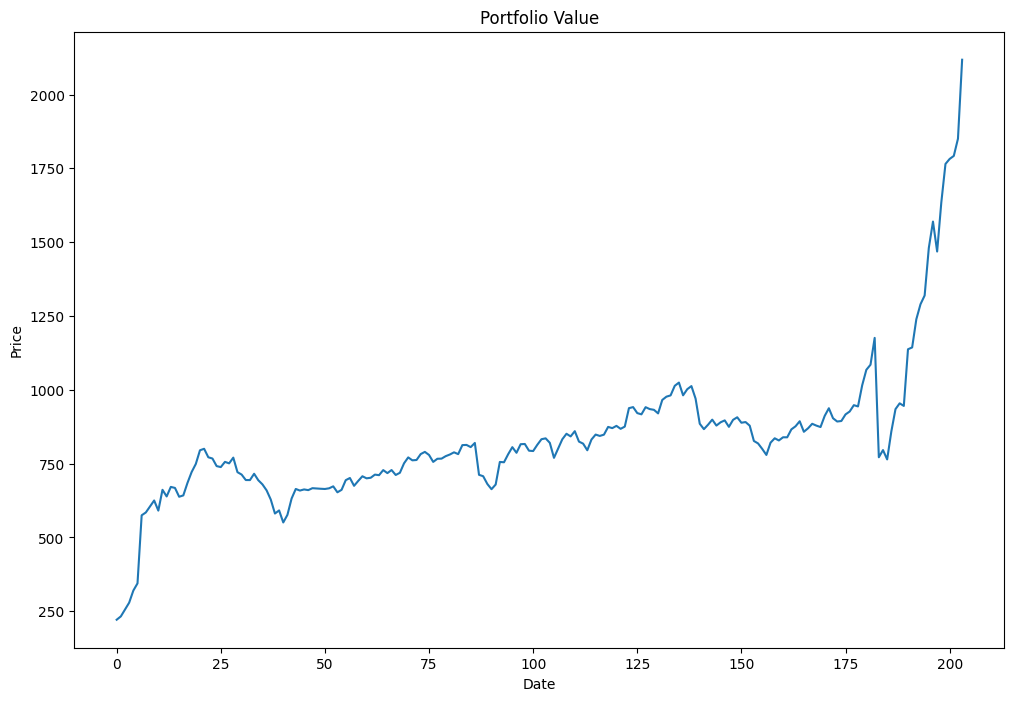

In [39]:
correct_order = portfoliodf['Total_Portfolio_Value'][::-1].to_list()
dates = portfoliodf['DATE'][::-1].to_list()
plt.figure(figsize=(12,8))
plt.plot(correct_order)
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Machine Learning Classifier Features Dataframe

In [66]:
mldf = pd.read_csv("/content/drive/MyDrive/Classifier_features.csv")
mldf = mldf.drop(columns=["Unnamed: 0"])
mldf.head(10)

,score,sentiment,compound,orgs_AAPL,orgs_AMC,orgs_AMD,orgs_AMZN,orgs_BB,orgs_GME,orgs_MU,orgs_NIO,orgs_NOK,orgs_NVDA,orgs_PLTR,orgs_RH,orgs_SNAP,orgs_SPCE,orgs_SPY,orgs_TSLA
0,11,1,0.5267,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,8,1,0.8481,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,30,-1,-0.1779,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,7,1,0.4767,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,219,-1,-0.8537,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
5,86,-1,-0.1779,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
6,13,0,0.0000,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
7,36,-1,-0.5574,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8,37,1,0.3089,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
9,18,1,0.5267,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [68]:
labelsdf = pd.read_csv("/content/drive/MyDrive/Classifier_labels.csv")
labelsdf = labelsdf.drop(columns=["Unnamed: 0"])
labelsdf.value_counts()

0
1    10743
0     2930
Name: count, dtype: int64

# Functions

In [5]:
def calculate_sentiment(text):
    pol_score = sia.polarity_scores(text)
    if pol_score['compound'] >= 0.05:
        return 1
    elif pol_score['compound'] <= -0.05:
        return -1
    else:
        return 0

def calculate_sentiment_tb(text,compound=True):
    blob = TextBlob(text)

    if compound:
        return blob.polarity

    else:
        if blob.polarity >= 0.05:
            return 1
        elif blob.polarity <= -0.05:
            return -1
        else:
            return 0

# find tickers and company names only from specified list
def find_tickers_and_names(title):
    doc = nlp_freq(title.upper())
    matches = matcher_freq(doc)
    found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
    tickers_list = set()
    for item in found_items:
        if item in company_names:
            tickers_list.add(company_names[item])
        else:
            tickers_list.add(item)
    for ticker in tickers_list:
        ticker_freq[ticker] += 1
    return '_'.join(tickers_list)

def get_daily_sentiment(dataframe, ticker, sentiment_type='compound'):

    df_ticker = dataframe.copy()[dataframe.orgs.str.contains(ticker)]
    df_ticker_scores = df_ticker.groupby(df_ticker['Date'])[sentiment_type].mean()
    df_ticker_scores = df_ticker_scores.to_frame()
    df_ticker_scores.reset_index(inplace=True)


    return df_ticker_scores

def get_prices(ticker, start, end):
    ticker = yf.Ticker(ticker)
    hist = ticker.history(start=start, end=end)
    hist = hist.reset_index()
    hist['Date'] = hist['Date'].apply(lambda x: x.date())
    hist = hist.set_index("Date")

    return hist[['Open']]

def get_range(ticker):
    gme_list = df.loc[df["orgs"] == ticker]['Date']
    gme_list = gme_list.reset_index(drop=True)
    small = gme_list[len(gme_list)-1]
    big = gme_list[:1][0]

    return(small, big)

def get_change(x):
  day = x['PRICE_day']
  week = x['PRICE_week']

  if day == 0:
    return -1
  try:
    if isinstance(day, dict):
      prices = list(day.values())
      prices2 = list(week.values())

      result = {}

      for key in day:
          if week[key] > day[key]:
              result[key] = 1
          elif week[key] < day[key]:
              result[key] = 0
      return result

    else:
        if week > day:
          return 1
        return 0
  except:
    return -1


def get_rolling_ratio(start):
  rolling_ratio = {}
  for i in portfolio:
    rolling_ratio[i] = [0,0]

  dates = good['Date']
  all_dates = dates.unique()
  first_week = all_dates[start:start+7]

  start_of_week = first_week[0]

  for day in first_week:
    posts = good.loc[good['Date'] == day]
    comps = posts['orgs'].unique()

    for i in comps:
      comp_posts = posts.loc[posts['orgs'] == i]

      try:
        values = comp_posts['PRICE_change'].to_list()[0]

        if "_" in i:
          values = ast.literal_eval(values)

          for c in values.keys():
            if values[c] == 1:
                rolling_ratio[c][0] += 1
            if values[c] == 0:
                rolling_ratio[c][1] += 1

        else:
          if values == 1:
            rolling_ratio[i][0] += 1
          if values == 0:
            rolling_ratio[i][1] += 1

      except:
        continue

  return [start_of_week, rolling_ratio]

In [ ]:
import datetime as dt

def get_week_price(post):
  try:
    if "_" in post['orgs']:
      companies = post['orgs'].split("_")
      prices = {}
      for i in companies:
        date = str(post['Date'] + dt.timedelta(days=7))
        price = list(dfs.loc[dfs['DATE'] == date, i])[0]
        prices[i] = price
      return prices

    else:
      company = post['orgs']
      date = str(post['Date'] + dt.timedelta(days=7))
      price = list(dfs.loc[dfs['DATE'] == date, company])[0]
      return price
  except:
    return 0

def get_day_price(post):
  try:
    if "_" in post['orgs']:
      companies = post['orgs'].split("_")
      prices = {}
      for i in companies:
        date = str(post['Date'])
        price = list(dfs.loc[dfs['DATE'] == date, i])[0]
        prices[i] = price
      return prices

    else:
      company = post['orgs']
      date = str(post['Date'])
      price = list(dfs.loc[dfs['DATE'] == date, company])[0]
      return price
  except:
    return 0

# Data Processing

In [6]:
target_stocks = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
company_names = {'S&P': 'SPY', 'GAMESTOP': 'GME', 'AMC': 'AMC', 'TESLA': 'TSLA', 'PALANTIR': 'PLTR', 'APPLE': 'AAPL', 'AMD': 'AMD', 'BLACKBERRY': 'BB',
                 'AMAZON': 'AMZN', 'NIO': 'NIO', 'NVIDIA': 'NVDA', 'MICRON': 'MU', 'RESTORATION': 'RH', 'SNAPCHAT': 'SNAP', 'NOKIA': 'NOK', 'VIRGIN': "SPCE"}

nlp_freq = sp.blank('en')
matcher_freq = PhraseMatcher(nlp_freq.vocab, attr='TEXT')
freq_token_list = [nlp_freq(item) for item in target_stocks + list(company_names)]
matcher_freq.add('Freq Stocks', freq_token_list)


In [ ]:
cols = ['symbol', 'id']

test = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')
tickers = pd.read_csv('/content/drive/MyDrive/ticker.txt',
                      delimiter = "\t", header=None, names = cols)

In [12]:
smaller = test.loc[test['score'] > 1]

In [ ]:
cols = ['symbol', 'id']
tickers['symbol'] = tickers['symbol'].str.upper()
tickers = tickers.dropna()
ticker_freq = Counter()

smaller['orgs'] = smaller.apply(lambda x: find_tickers_and_names(x.title), axis=1)
smaller = smaller[['orgs', 'score', 'title', 'created_utc']]

# Posts Semantic Processing

In [17]:
new_words = pd.read_csv("/content/drive/MyDrive/vadersemantics.csv")
new_words.head()
words = {}
for i in range(len(new_words)):
  row = new_words.iloc[i]
  words[row['Word']] = row['Score']

sia = SIA()

sia.lexicon.update(words)

smaller['sentiment'] = smaller.apply(lambda x: calculate_sentiment(x.title), axis=1)
smaller['compound'] = smaller.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)

In [18]:
good = smaller.loc[smaller['orgs'] != ""]
good = good.reset_index(drop=True)
good['Date'] = pd.to_datetime(good['created_utc'],unit='s').dt.date

In [19]:
week_prices = []
prices = []

for i in range(len(good)):
  prices.append(get_day_price(good.iloc[i]))
for i in range(len(good)):
  week_prices.append(get_week_price(good.iloc[i]))

first = pd.Series(week_prices)
second = pd.Series(prices)
good['PRICE_day'] = second
good['PRICE_week'] = first

changes = []
for i in range(len(good)):
  changes.append(get_change(good.iloc[i]))

third = pd.Series(changes)
good['PRICE_change'] = third

NameError: name 'get_day_price' is not defined

# BULL/BEAR Ratio

In [ ]:
good = pd.read_csv('/content/drive/My Drive/LARGER_DF_16_04_2024.csv')

In [ ]:
stocks = pd.read_csv('/content/drive/My Drive/stocks_17_04_2024.csv')

In [ ]:
cls = ['Date', 'SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
portfolio = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']

In [ ]:
positions = pd.DataFrame(columns = cls)
positions

,Date,SPY,GME,AMC,TSLA,PLTR,AAPL,AMD,BB,AMZN,NIO,NVDA,MU,RH,SNAP,NOK,SPCE


In [ ]:
week_ratio = {}
for i in portfolio:
  week_ratio[i] = 0

for i in range(0, len(good), 7):
  start = i
  try:
    ratio = get_rolling_ratio(start)
  except:
    break

  date = ratio[0]
  ratio = ratio[1]

  for i in ratio.keys():
    val = ratio[i]
    pos = val[0]
    neg = val[1]
    total = pos + neg

    if total == 0:
      week_ratio[i] = 0.50
    else:
      bullbear = pos / total
      week_ratio[i] = round(bullbear, 2)

  week_ratio['Date'] = date

  positions.loc[len(positions)] = week_ratio


In [ ]:
positions.head()

,Unnamed: 0,Date,SPY,GME,AMC,TSLA,PLTR,AAPL,AMD,BB,AMZN,NIO,NVDA,MU,RH,SNAP,NOK,SPCE
0,0,2021-02-16,0.5,0.50,0.50,0.50,0.5,0.5,0.50,0.50,0.50,0.5,0.5,0.5,0.5,0.5,0.50,0.5
1,1,2021-02-08,1.0,0.00,0.00,0.57,1.0,1.0,1.00,0.74,0.25,0.5,0.5,0.5,1.0,0.5,0.00,0.5
2,2,2021-01-30,1.0,0.13,0.05,0.90,0.3,0.0,0.33,0.00,1.00,0.0,0.5,0.5,1.0,0.5,0.03,1.0
3,3,2021-01-23,0.5,1.00,0.50,0.33,1.0,0.5,1.00,1.00,1.00,0.5,1.0,0.5,0.0,1.0,1.00,1.0
4,4,2021-01-16,0.5,1.00,1.00,0.50,0.6,0.5,0.50,1.00,0.50,0.0,0.5,0.5,0.0,0.5,0.50,1.0


# Empirical Analysis

In [ ]:
portfolio = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']

In [ ]:
positions = pd.read_csv('/content/drive/My Drive/positions_17_04_2024.csv')
stocks = pd.read_csv('/content/drive/My Drive/stocks_17_04_2024.csv')
good = pd.read_csv('/content/drive/My Drive/LARGER_DF_16_04_2024.csv')

In [ ]:
start = stocks['DATE'].iloc[0]
end = stocks['DATE'].iloc[-1]
print(start, end)

2012-05-21 2021-02-12


In [ ]:
spy = stocks['SPY']
start = spy.iloc[0]
end = spy.iloc[-1]
print(round((end / start)*100, 2), "% Total Increase from S&P500 9 year return")

299.52 % Total Increase from S&P500 9 year return


In [ ]:
port_plot = stocks[portfolio]

start = port_plot.iloc[600].to_list()
start = sum(num for num in start if not math.isnan(num))
end = port_plot.iloc[-1].to_list()
end = sum(num for num in end if not math.isnan(num))
print(round((end / start)*100, 2), "% Total Increase from entire Portfolio 9 year return")

329.81 % Total Increase from entire Portfolio 9 year return


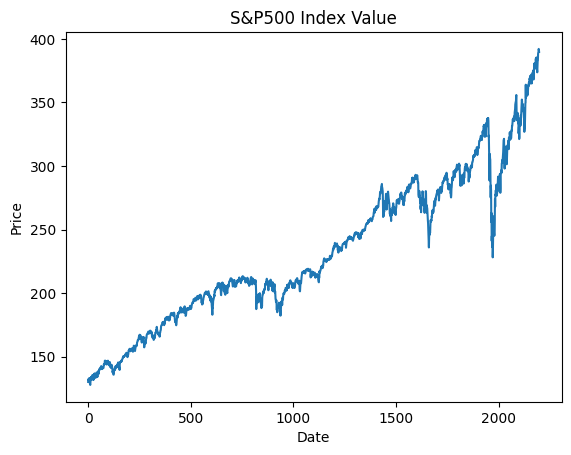

In [ ]:
spy = stocks['SPY']
plt.plot(spy)
plt.title('S&P500 Index Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

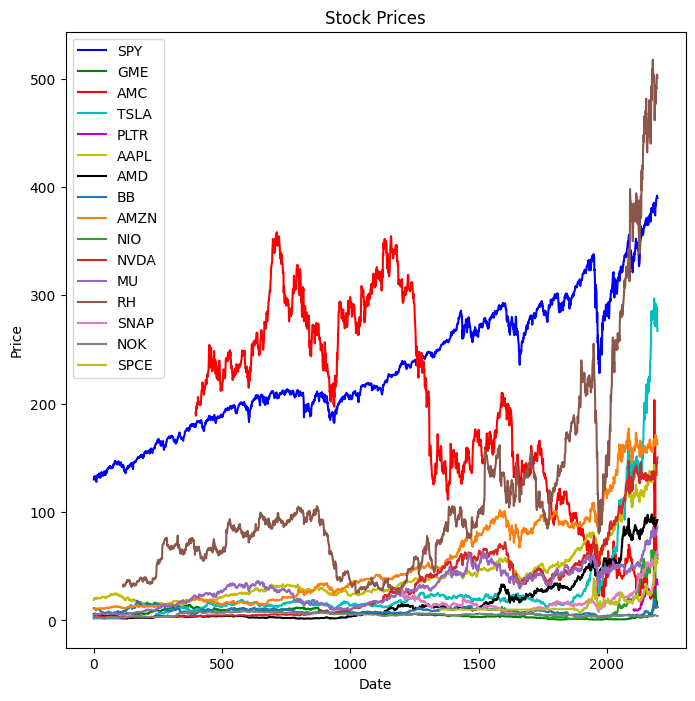

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']

plt.figure(figsize=(8, 8))
for i, column in enumerate(port_plot.columns):
    plt.plot(port_plot.index, port_plot[column], label=column, color=colors[i])

plt.title('Porfolio Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
share = pd.read_csv("/content/drive/MyDrive/TOTAL_SHARE_STOCKS.csv")

In [ ]:
total = sum(share['count'])
share['Percentage'] = round(share['count'] / total, 2)

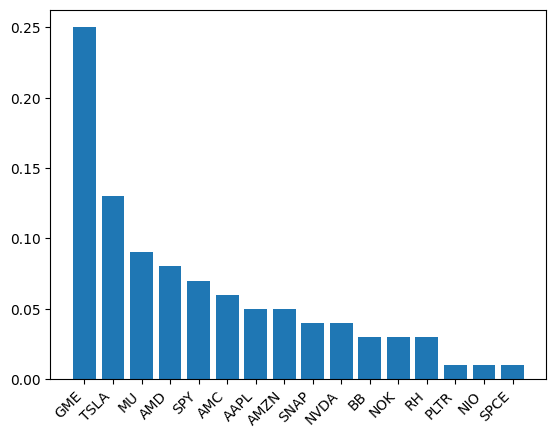

In [ ]:
x = share['orgs']
y = share['Percentage']
plt.bar(x,y)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#positions = positions.drop(columns=['Unnamed: 0'])
df1 = positions.copy()

columns_to_multiply = [col for col in df1.columns if col != 'Date']

df1[columns_to_multiply] *= 2
df1 = df1.rename(columns = {'Date':'DATE'})
df1.head()

confidence_df = df1

In [ ]:
#stocks = stocks.drop(columns=['Unnamed: 0'])
stocks[len(stocks)-10:]
df2 = stocks
df2.head()
stock_values_df = df2

In [ ]:
merged_df = pd.merge(confidence_df, stock_values_df, on='DATE')

for column in confidence_df.columns[1:]:
    if column in merged_df.columns:
        merged_df[column] *= merged_df[column+"_x"]

portfolio_columns = [col for col in merged_df.columns if col not in confidence_df.columns]
merged_df['Total_Portfolio_Value'] = merged_df[portfolio_columns].sum(axis=1)


In [ ]:
merged_df = pd.read_csv("/content/drive/MyDrive/Total_Portfolio_Value_1.csv")

In [ ]:
merged_df

,Unnamed: 0,DATE,SPY_x,GME_x,AMC_x,TSLA_x,PLTR_x,AAPL_x,AMD_x,BB_x,...,NIO_y,NOK_y,NVDA_y,PLTR_y,RH_y,SNAP_y,SPCE_y,SPY_y,TSLA_y,Total_Portfolio_Value
0,0,2021-02-08,2.0,0.0,0.0,1.14,2.0,2.0,2.0,1.48,...,57.080002,4.28,137.272507,37.220001,490.690002,63.340000,55.990002,389.269989,289.890015,2117.850021
1,1,2020-12-24,1.0,2.0,1.0,2.00,2.0,2.0,1.0,1.00,...,46.880001,3.90,130.372498,28.798000,466.950012,51.919998,26.809999,368.079987,214.330002,1850.438012
2,2,2020-12-10,1.0,1.0,1.0,1.00,2.0,1.0,1.0,2.00,...,42.439999,4.13,128.690002,25.541000,452.500000,48.849998,30.230000,365.369995,191.456665,1792.127157
3,3,2020-12-02,1.0,1.0,1.0,1.00,0.0,1.0,1.0,1.00,...,40.160000,3.99,133.505005,22.240000,449.190002,44.430000,28.000000,364.820007,185.479996,1781.822510
4,4,2020-11-24,2.0,1.0,1.0,2.00,2.0,0.0,2.0,1.00,...,56.990002,4.03,131.425003,22.350000,448.309998,45.599998,25.190001,360.209991,180.133331,1764.860822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,199,2013-05-28,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.00,...,NaN,3.66,3.662500,NaN,54.939999,NaN,NaN,167.039993,6.770000,320.066850
200,200,2013-02-20,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.00,...,NaN,3.90,3.150000,NaN,39.070000,NaN,NaN,153.139999,2.620000,279.171070
201,201,2012-11-06,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.00,...,NaN,2.77,3.262500,NaN,33.400002,NaN,NaN,142.279999,2.040667,255.585811
202,202,2012-09-14,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.00,...,NaN,3.01,3.417500,NaN,NaN,NaN,NaN,146.880005,2.000000,232.678934


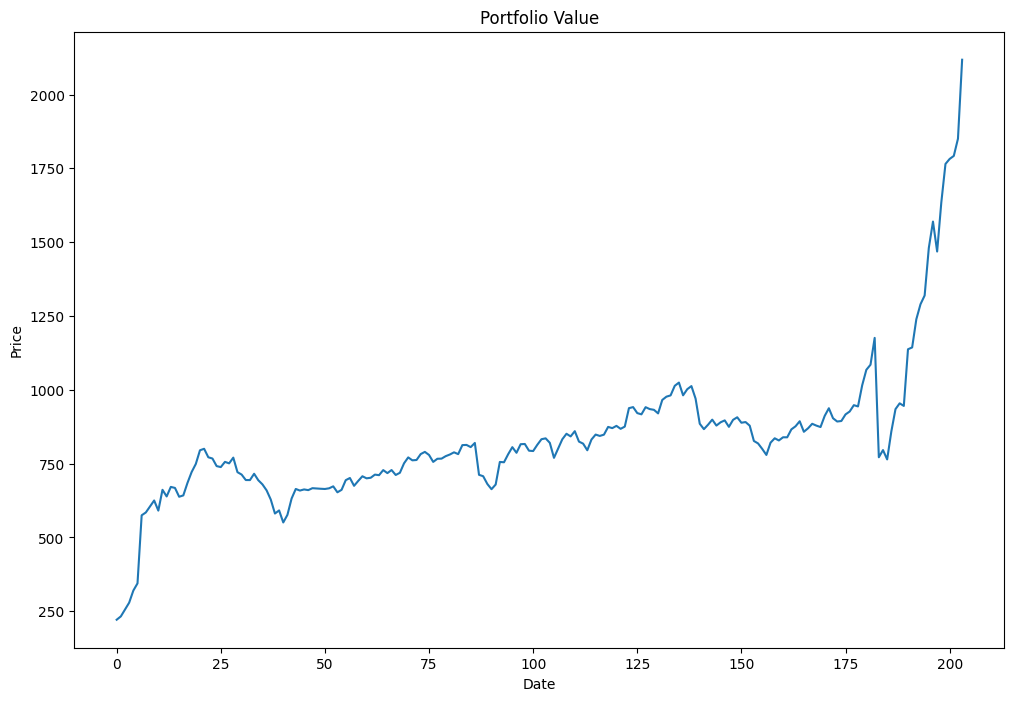

In [ ]:
correct_order = merged_df['Total_Portfolio_Value'][::-1].to_list()
dates = merged_df['DATE'][::-1].to_list()
plt.figure(figsize=(12,8))
plt.plot(correct_order)
plt.title('Portfolio Value')
#plt.xticks(rotation=90, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [ ]:
test = correct_order
test2 = [item for item in test for _ in range(10)]

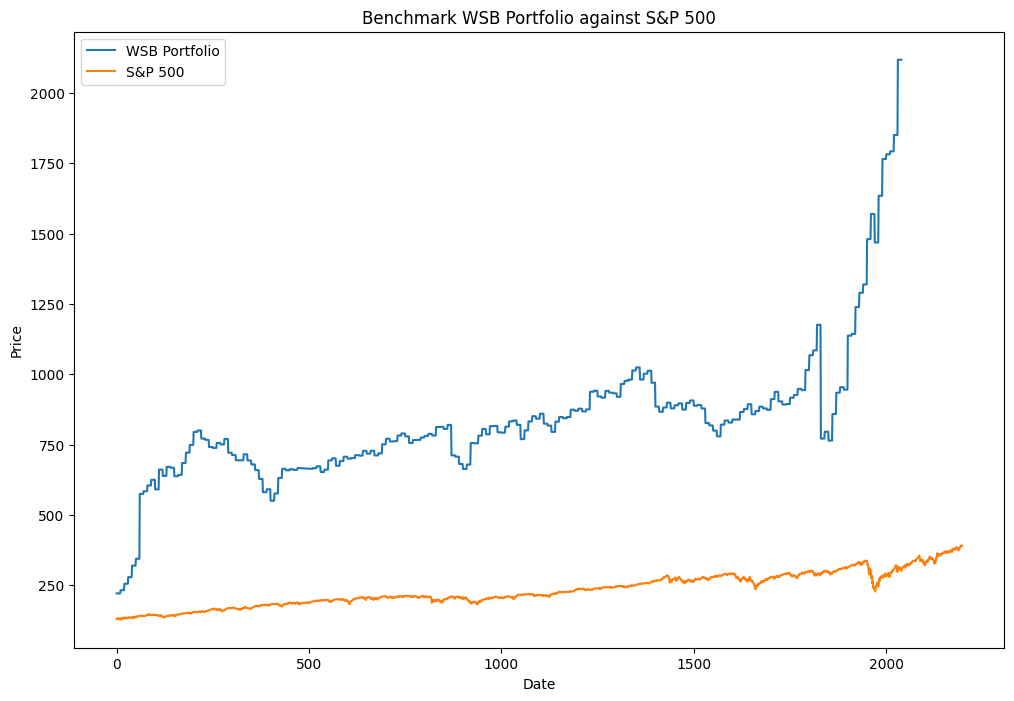

In [ ]:
spy = stocks['SPY']
correct_order = merged_df['Total_Portfolio_Value'][::-1].to_list()
plt.figure(figsize=(12,8))
plt.plot(test2, label='WSB Portfolio')
plt.plot(spy, label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Benchmark WSB Portfolio against S&P 500")
plt.legend()
plt.show()

In [ ]:
start = correct_order[0]
finish = correct_order[-1]
print(round((finish/start)*100, 2), "% increase in WSB Portfolio value over 9 years backtest")

956.67 % increase in WSB Portfolio value over 9 years backtest


# Classification Model

In [40]:
def get_first_price(x):
  if len(str(x)) > 2:
    values = ast.literal_eval(x)
    for i in values.keys():
      return int(values[i])
  else:
    return int(x)



In [41]:
def check_single(x):
  if "_" not in x:
    return x
  else:
    return ""

def get_single(x):
  if "_" in x:
    orgs = x.split("_")
    return orgs[0]
  else:
    return x

In [59]:
good['PRICE_change'] = good['PRICE_change'].apply(lambda x: get_first_price(x))
good['orgs'] = good['orgs'].apply(lambda x: get_single(x))

In [60]:
dummies = pd.get_dummies(good, columns=['orgs'])

In [61]:
filter = dummies[dummies['PRICE_change'] != 0]

In [62]:
X= filter.drop(columns=['PRICE_change', 'Unnamed: 0', 'title', 'created_utc', 'Date', 'PRICE_day', 'PRICE_week'])
y = filter['PRICE_change']

In [63]:
y = pd.Series([0 if x == -1 else x for x in y])
y.value_counts()

1    10743
0     2930
Name: count, dtype: int64

In [47]:
X.head()

,score,sentiment,compound,orgs_AAPL,orgs_AMC,orgs_AMD,orgs_AMZN,orgs_BB,orgs_GME,orgs_MU,orgs_NIO,orgs_NOK,orgs_NVDA,orgs_PLTR,orgs_RH,orgs_SNAP,orgs_SPCE,orgs_SPY,orgs_TSLA
0,11,1,0.5267,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,8,1,0.8481,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,30,-1,-0.1779,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,7,1,0.4767,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,219,-1,-0.8537,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [64]:
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7630712979890311


In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}
for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X, y, cv=5)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression:
Accuracy: 0.7844657353909164
Precision: 0.7860707471011302
Recall: 0.9970213162059015
F1 Score: 0.8790676679387747

Random Forest:
Accuracy: 0.7154976961895707
Precision: 0.7870486721956941
Recall: 0.8745229451736014
F1 Score: 0.8284832451499118

Support Vector Machine:
Accuracy: 0.7843194617128648
Precision: 0.7856200527704486
Recall: 0.9977659871544261
F1 Score: 0.8790749169639561

Gradient Boosting:
Accuracy: 0.7709354201711403
Precision: 0.7842258570468295
Recall: 0.9773806199385646
F1 Score: 0.870213823968175



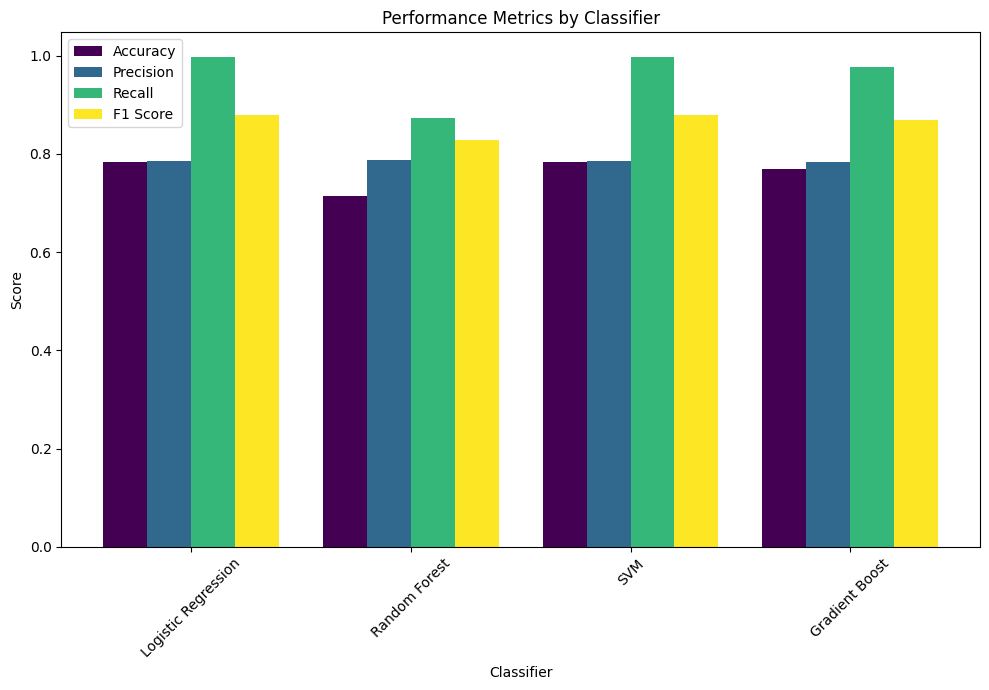

In [52]:
import matplotlib.pyplot as plt
import numpy as np

results = {
    "Logistic Regression": {
        "Accuracy": 0.7844657353909164,
        "Precision": 0.7860707471011302,
        "Recall": 0.9970213162059015,
        "F1 Score": 0.8790676679387747
    },
    "Random Forest": {
        "Accuracy": 0.7146200541212608,
        "Precision": 0.7867382010227177,
        "Recall": 0.8735921064879456,
        "F1 Score": 0.827893436838391
    },
    "SVM": {
        "Accuracy": 0.7843194617128648,
        "Precision": 0.7856200527704486,
        "Recall": 0.9977659871544261,
        "F1 Score": 0.8790749169639561
    },
    "Gradient Boost": {
        "Accuracy": 0.770204051780882,
        "Precision": 0.7841070494131719,
        "Recall": 0.9763566973843433,
        "F1 Score": 0.8697346600331676
    }
}

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

fig, ax = plt.subplots(figsize=(10, 7))

bar_width = 0.2
num_metrics = len(metrics)
bar_positions = np.arange(len(results))

colors = plt.cm.viridis(np.linspace(0, 1, num_metrics))

for i, metric in enumerate(metrics):
    x = [name for name in results.keys()]
    y = [results[name][metric] for name in results.keys()]
    ax.bar(bar_positions + i * bar_width, y, width=bar_width, label=metric, color=colors[i])

ax.set_xlabel("Classifier")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics by Classifier")
ax.set_xticks(bar_positions + bar_width * (num_metrics - 1) / 2)
ax.set_xticklabels(results.keys())
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
